In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
## Load helper functions
%run Helper.ipynb

In [2]:
camera = "camera_c"
raw_data = f'Raw data/{camera}' # Location of yolodeepsort output txt files 
out_data = f'Outputs/{camera}' # Location to save processed data
videos = f'../Footage/tampines_footage/{camera}' # Location of video files
bg_path = f'{out_data}/bg_img.png'
plan = f'Inputs/plan.jpg'
real_h, real_w = (4000, 12000)

In [3]:
data_in = f'{out_data}/Cleaned_data.csv'

In [4]:
df_In = pd.read_csv(data_in)

In [5]:
coordinates={
    "camera_a":{
        "target":[
            [240,1362],
            [995, 1112],
#             [1004,1206],
#             [1385,1138],
            [1257,1447],
            [3211,1447],
            [3211,1783],
            [282, 1783]
        ],
        "src":
        [
            [275,663],
            [591,472],
#             [685, 479],
#             [776,435],
            [989,447],
            [1205,359],
            [1370,359],
            [1331,760],
            

            
        ]
    },
    "camera_c":{
        "target":[
            [437,317],
            [894, 317],
            [894,398],
            [437,398],
            [437,350],
            [894,350]
#             [775,317],
#             [894, 317],
#             [894,398],
#             [775,398]
#             [1575,868],
#             [1960,868],
#              [1960,1142],
#              [1575,1142],

        ],
        "src":
        [
#             [1122,146],
#             [1496,259],
#             [677,464],
#              [605,240],
            [782,57],
            [1496,259],
            [677,464],
             [563,96],
            [693, 72],
            [1266, 320],

            

            
        ]
    }
}

1920 1080


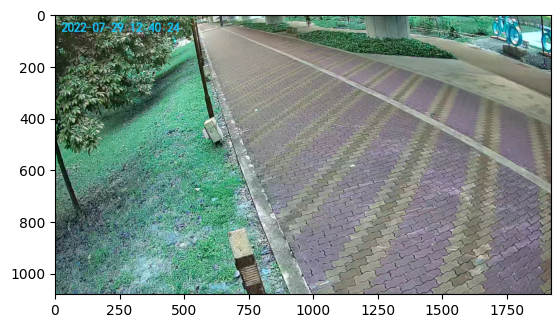

In [6]:
im_src = cv2.imread(bg_path)
height, width, channels = im_src.shape
print(width, height)
# plt.axis('off')
plt.imshow(im_src)
# cv2.imshow(im_src)

In [7]:
colors = [
    [255,0,0],
    [0,255,0],
    [0,0,255],
     [0,0,0],
        [255,0,0],
    [0,255,0],
    [0,0,255],
     [0,0,0],
        [255,0,0],
    [0,255,0],
    [0,0,255],
     [0,0,0],
        [255,0,0],
    [0,255,0],
    [0,0,255],
     [0,0,0],
    
]
red = (255,0,0)

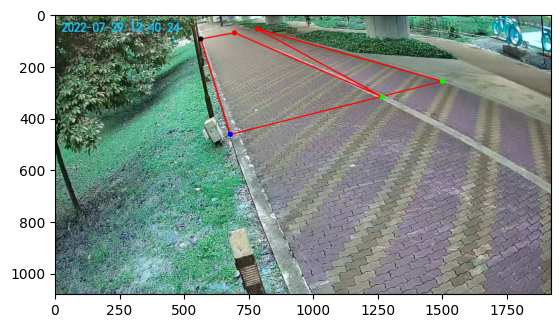

In [8]:
src_coordinates = coordinates["camera_c"]["src"]
im_src_ = im_src.copy()
src_pts = np.array(src_coordinates,
               np.int32)
 
src_pts = src_pts.reshape((-1, 1, 2))
isClosed = True
im_src_ = cv2.polylines(im_src_, [src_pts],
                      isClosed, red,3)
 
for i,(x,y) in enumerate(src_coordinates):
    im_src_ = cv2.circle(im_src_, (int(x),int(y)), radius=10, color=colors[i], thickness=-1)
# plt.axis('off')
plt.imshow(im_src_)

1754 588


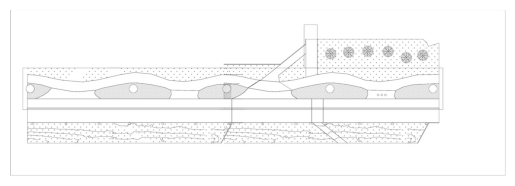

In [9]:
im_target = cv2.imread(plan)
height, width, channels = im_target.shape
print(width, height)
plt.axis('off')
plt.imshow(im_target)

In [10]:
dot_coordinates = df_In[["bbox_middle","bbox_bottom"]].values.tolist()

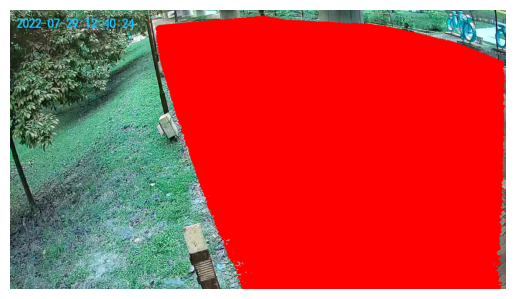

In [11]:
im_dots_ = im_src.copy()

for x,y in dot_coordinates:
    im_dots_ = cv2.circle(im_dots_, (int(x),int(y)), radius=5, color=red, thickness=-1)
plt.axis('off')
plt.imshow(im_dots_)

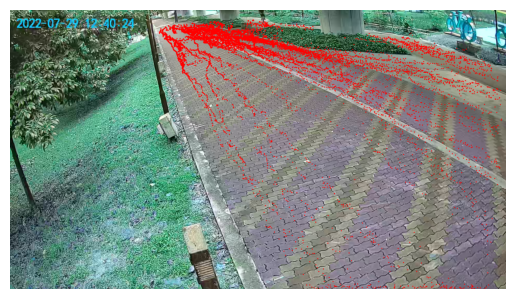

In [31]:
sample = df_In[df_In['video'] == "220729/174812_248_179_T"].copy()
sample['timeStamp'] = pd.to_datetime(sample['timeStamp'])
sample_dot_coordinates = sample[["bbox_middle","bbox_bottom"]].values.tolist()

im_dots_ = im_src.copy()

for x,y in sample_dot_coordinates:
    im_dots_ = cv2.circle(im_dots_, (int(x),int(y)), radius=2, color=red, thickness=-1)
plt.axis('off')
plt.imshow(im_dots_)



In [34]:
sample['timeStamp_s'] =sample['timeStamp'].dt.round("s")

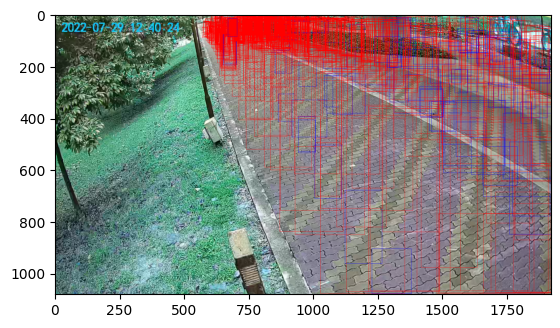

In [37]:

fil = sample.groupby(['uid','timeStamp_s']).first().reset_index()
bboxVis(fil,im_src)

# Resize coordinates and plan based on real world dimensions

In [12]:
im_h, im_w, im_c = im_target.shape
target_coordinates = coordinates["camera_c"]["target"]
target_coordinates = [[(real_w * x/im_w),(real_h * y/im_h)] for [x,y] in target_coordinates]

In [13]:
target_coordinates

[[2989.7377423033067, 2156.4625850340135],
 [6116.305587229191, 2156.4625850340135],
 [6116.305587229191, 2707.482993197279],
 [2989.7377423033067, 2707.482993197279],
 [2989.7377423033067, 2380.9523809523807],
 [6116.305587229191, 2380.9523809523807]]

In [14]:
im_target_real = cv2.resize(im_target, (real_w, real_h), interpolation = cv2.INTER_AREA)

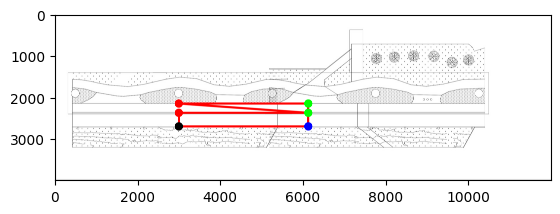

In [15]:
target_pts = np.array(target_coordinates,
               np.int32)


im_target_real_ = im_target_real.copy() 
target_pts = target_pts.reshape((-1, 1, 2))
isClosed = True
im_target_real_ = cv2.polylines(im_target_real_, [target_pts],
                      isClosed, red,50)


for i,(x,y) in enumerate(target_coordinates):
    im_target_real_ = cv2.circle(im_target_real_, (int(x),int(y)), radius=100, color=colors[i], thickness=-1)

# plt.axis('off')    
plt.imshow(im_target_real_)

# Calculate homography

In [16]:
im_dst = np.zeros(im_src.shape,dtype=np.uint8)

## generate target coordinates for the input coordinates
pts_dst = np.empty((0,2))
for x,y in target_coordinates:
    pts_dst = np.append(pts_dst, [(x,y)], axis=0)

pts_src = np.empty((0,2))

for x,y in src_coordinates:
    pts_src = np.append(pts_src, [(x,y)], axis=0)
    
print(pts_src)

[[ 782.   57.]
 [1496.  259.]
 [ 677.  464.]
 [ 563.   96.]
 [ 693.   72.]
 [1266.  320.]]


In [17]:
tform, status = cv2.findHomography(pts_src, pts_dst)

## Apply homography

In [18]:
centroid_x = df_In["bbox_middle"].values.tolist()
centroid_y = df_In["bbox_bottom"].values.tolist()


length = len(centroid_x)

if len(centroid_x) != len(centroid_y):
    print("You have a different number of x and y values")

new_x = np.zeros(length, dtype = 'double')
new_y = np.zeros(length, dtype = 'double')
old_point = np.array([[0.0],[0.0],[1.0]])
new_point = np.array([[0.0],[0.0],[1.0]])

for i in range(length):
    old_point[0,0] = centroid_x[i]
    old_point[1,0] = centroid_y[i]
    new_point = np.dot(tform, old_point)
    new_point = new_point / new_point[2,0]
    if new_point[2,0] != 1:
        print("The values are not normalized properly")
        break;
    new_x[i] = new_point[0,0]
    new_y[i] = new_point[1,0]


# new_data = np.zeros((len(data), len(data[0])), dtype = 'double')

# for x in range(len(data)):
#     for y in range(len(data[0])):
#         new_data[x,y] = data[x,y]

# for i in range(length):
#     new_data[i,9] = new_x[i]
#     new_data[i,10] = new_y[i]

# print(data[0])
# print(new_data[0])
print(max(new_x))
print(max(new_y))



6950.301342830783
2760.3757219096824


## Add new centroids to dataframe

In [19]:
df_In["plan_X"] = new_x
df_In["plan_Y"] = new_y
df_In[["plan_X","plan_Y"]] = df_In[["plan_X","plan_Y"]].astype('int')

df_In.head()

,frame,bbox_left,bbox_top,bbox_w,bbox_h,class,video,class_name,vid_id,timeStamp,...,bbox_right,bbox_bottom,bbox_middle,filter_ooi,filter_roi,context_iou,filter_context,intersects_line,plan_X,plan_Y
0,2,627,66,48,110,0,220730/064842_248_179_T,person,406,2022-07-30 06:48:42.100,...,675,176,651,True,True,0.0,True,False,4666,2633
1,3,628,65,45,109,0,220730/064842_248_179_T,person,406,2022-07-30 06:48:42.160,...,673,174,650,True,True,0.0,True,False,4642,2632
2,4,626,65,46,109,0,220730/064842_248_179_T,person,406,2022-07-30 06:48:42.210,...,672,174,649,True,True,0.0,True,False,4640,2633
3,5,626,66,46,107,0,220730/064842_248_179_T,person,406,2022-07-30 06:48:42.260,...,672,173,649,True,True,0.0,True,False,4629,2632
4,6,627,66,45,108,0,220730/064842_248_179_T,person,406,2022-07-30 06:48:42.310,...,672,174,649,True,True,0.0,True,False,4640,2633


## Visualise plan

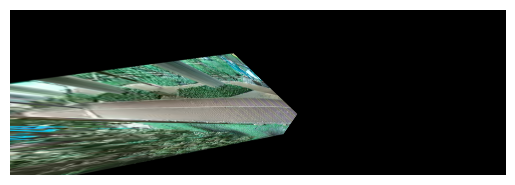

In [20]:
im_dst = cv2.warpPerspective(im_src, tform,(im_target_real.shape[1], im_target_real.shape[0]))
plt.axis('off')
plt.imshow(im_dst)

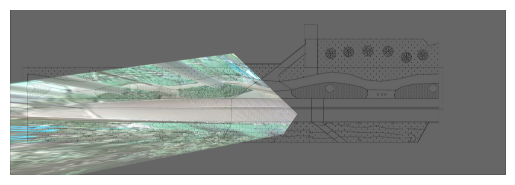

In [21]:
im_dst_ = im_dst.copy()

overlay = im_target_real.copy()

  
alpha = 0.4  # Transparency factor.

im_dst_ = cv2.addWeighted(im_target_real, alpha, im_dst_, 1-alpha, 0)
plt.axis('off')
plt.imshow(im_dst_)

In [22]:
new_coordinates = df_In[["plan_X","plan_Y"]].values.tolist()
# .values.tolist()


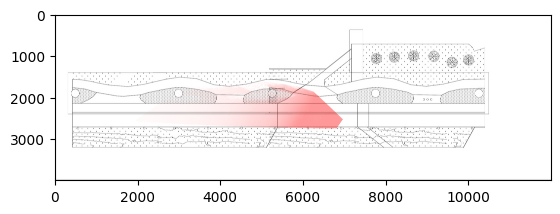

In [23]:
im_dst_ = im_target_real.copy()

overlay = im_dst_.copy()

  
alpha = 0.4  # Transparency factor.

  
# cv2.imshow("some", image_new)
# cv2.waitKey(0)
  
# cv2.destroyAllWindows()


for i,(x,y) in enumerate(new_coordinates):
    cv2.circle(overlay, (int(x),int(y)), radius=1, color=(255,0,0), thickness=-1)

im_dst_ = cv2.addWeighted(overlay, alpha, im_dst_, 1-alpha, 0)
# plt.axis('off')
plt.imshow(im_dst_)

In [24]:
df_In.columns

Index(['frame', 'bbox_left', 'bbox_top', 'bbox_w', 'bbox_h', 'class', 'video',
       'class_name', 'vid_id', 'timeStamp', 'uid', 'bbox_right', 'bbox_bottom',
       'bbox_middle', 'filter_ooi', 'filter_roi', 'context_iou',
       'filter_context', 'intersects_line', 'plan_X', 'plan_Y'],
      dtype='object')

In [25]:
df_Out = df_In.loc[:, ~df_In.columns.isin(['filter_ooi', 'filter_roi', 'filter_context'])]


In [26]:
df_Out.head()

,frame,bbox_left,bbox_top,bbox_w,bbox_h,class,video,class_name,vid_id,timeStamp,uid,bbox_right,bbox_bottom,bbox_middle,context_iou,intersects_line,plan_X,plan_Y
0,2,627,66,48,110,0,220730/064842_248_179_T,person,406,2022-07-30 06:48:42.100,1,675,176,651,0.0,False,4666,2633
1,3,628,65,45,109,0,220730/064842_248_179_T,person,406,2022-07-30 06:48:42.160,1,673,174,650,0.0,False,4642,2632
2,4,626,65,46,109,0,220730/064842_248_179_T,person,406,2022-07-30 06:48:42.210,1,672,174,649,0.0,False,4640,2633
3,5,626,66,46,107,0,220730/064842_248_179_T,person,406,2022-07-30 06:48:42.260,1,672,173,649,0.0,False,4629,2632
4,6,627,66,45,108,0,220730/064842_248_179_T,person,406,2022-07-30 06:48:42.310,1,672,174,649,0.0,False,4640,2633


In [27]:
df_Out.to_csv(f'Outputs/{camera}/Homography.csv',index = False)